# Imports

In [1]:
# ==============================================================================
# 1. IMPORTS
# ==============================================================================

# --- Manejo de Datos ---
import os
import pandas as pd
import numpy as np
import warnings

# --- Pipeline y Preprocesamiento ---
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import Pool
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# --- Modelado ---
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost.callback import EarlyStopping as XGBEarlyStopping

# --- Métricas y Validación ---
from sklearn import metrics

# --- Visualización (incluyendo las usadas en celdas comentadas) ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.inspection import permutation_importance


# Ignorar warnings para una presentación más limpia
warnings.filterwarnings("ignore")

from typing import List, Optional, Dict, Tuple

In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:

# Leer parquet
df = pd.read_parquet("../data/df_merged.parquet")

# Revisar las primeras filas
print(df.head())


                       id              item    category    department  \
0  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
1  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
2  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
3  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
4  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   

       store store_code  region  yearweek  units_sold  sell_price    event  
0  South_End      BOS_1  Boston  201328.0           4     12.7414  Unknown  
1  South_End      BOS_1  Boston  201329.0           0     10.9858  Unknown  
2  South_End      BOS_1  Boston  201330.0           6     10.9858  Unknown  
3  South_End      BOS_1  Boston  201331.0           0     10.9858  Unknown  
4  South_End      BOS_1  Boston  201332.0           1     10.9858  Unknown  


In [4]:
# Paso 0: Calcular la columna de facturación (revenue)
df['revenue'] = df['units_sold'] * df['sell_price']
# Convertimos 'yearweek' (ej: 201328.0) a un formato de fecha para el eje X
# Cambiamos el día de la semana a Jueves ('4') según la nueva regla de negocio
df['date'] = pd.to_datetime(df['yearweek'].astype(int).astype(str) + '4', format='%Y%W%w')

In [5]:
for col in df.select_dtypes(include=['category']).columns:
    num_unique_values = df[col].nunique()
    print(f'Columna: {col}, Valores únicos: {num_unique_values}')

Columna: id, Valores únicos: 30490
Columna: item, Valores únicos: 3049
Columna: category, Valores únicos: 3
Columna: department, Valores únicos: 7
Columna: store, Valores únicos: 10
Columna: store_code, Valores únicos: 10
Columna: region, Valores únicos: 3
Columna: event, Valores únicos: 6


In [6]:
df

,id,item,category,department,store,store_code,region,yearweek,units_sold,sell_price,event,revenue,date
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201328.0,4,12.7414,Unknown,50.965599,2013-07-18
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201329.0,0,10.9858,Unknown,0.000000,2013-07-25
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201330.0,6,10.9858,Unknown,65.914795,2013-08-01
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201331.0,0,10.9858,Unknown,0.000000,2013-08-08
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201332.0,1,10.9858,Unknown,10.985800,2013-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6721781,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,201613.0,22,1.2000,Easter,26.400002,2016-03-31
6721782,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,201614.0,14,1.2000,Unknown,16.800001,2016-04-07
6721783,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,201615.0,1,1.2000,Unknown,1.200000,2016-04-14
6721784,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,201616.0,0,1.2000,Unknown,0.000000,2016-04-21


In [7]:
# Ordenar por fecha antes del split temporal
df_sorted = df.sort_values("date")
target='units_sold'


In [8]:
df_sorted['date'].unique()

<DatetimeArray>
['2011-02-03 00:00:00', '2011-02-10 00:00:00', '2011-02-17 00:00:00',
 '2011-02-24 00:00:00', '2011-03-03 00:00:00', '2011-03-10 00:00:00',
 '2011-03-17 00:00:00', '2011-03-24 00:00:00', '2011-03-31 00:00:00',
 '2011-04-07 00:00:00',
 ...
 '2016-02-25 00:00:00', '2016-03-03 00:00:00', '2016-03-10 00:00:00',
 '2016-03-17 00:00:00', '2016-03-24 00:00:00', '2016-03-31 00:00:00',
 '2016-04-07 00:00:00', '2016-04-14 00:00:00', '2016-04-21 00:00:00',
 '2016-04-28 00:00:00']
Length: 274, dtype: datetime64[ns]

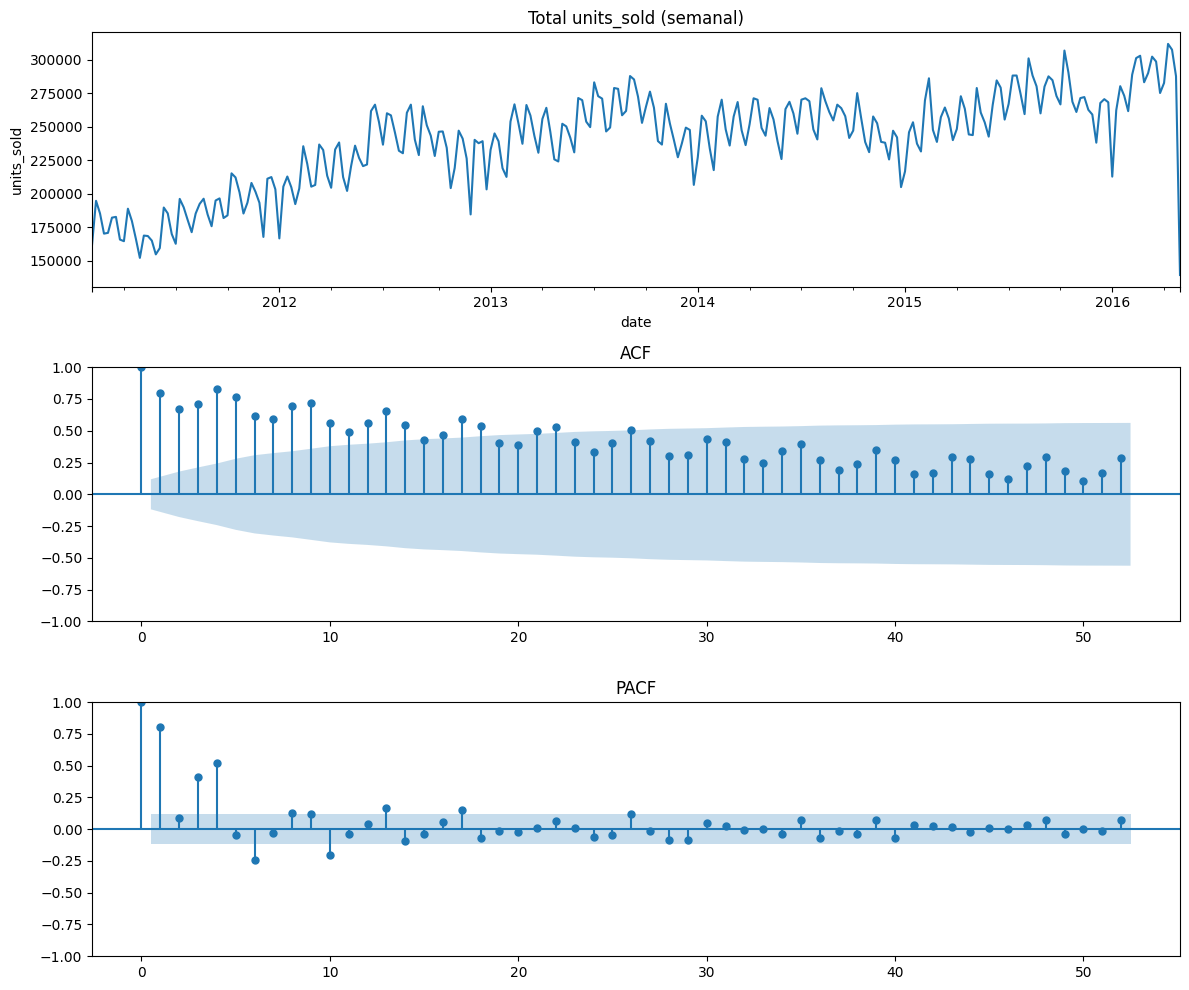

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_ts_acf_pacf(y, title, max_lag=52):
    """
    y : pandas.Series con índice DateTime (frecuencia semanal)
    max_lag : nº máximo de lags (en semanas) a mostrar
    """
    fig = plt.figure(figsize=(12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1, sharex=False)

    # Serie
    y.plot(ax=ax1, title=title)
    ax1.set_ylabel("units_sold")

    # ACF y PACF
    plot_acf(y, ax=ax2, lags=max_lag)
    plot_pacf(y, ax=ax3, lags=max_lag, method='ywm')

    ax2.set_title("ACF")
    ax3.set_title("PACF")
    plt.tight_layout()
    plt.show()

# 1️⃣  Serie semanal agregada (todas las tiendas/items)
weekly_series = (
    df_sorted
    .set_index("date")
    .resample("W")["units_sold"]   # 'W' = semanal
    .sum()
)

# 2️⃣  Graficar hasta 52 semanas (un año de lags)
plot_ts_acf_pacf(weekly_series, "Total units_sold (semanal)", max_lag=52)


# Feature Engineering:

In [10]:


def build_datasets(
    df_sorted: pd.DataFrame,
    split_frac: float = 0.80,
    ohe_cols = ('category','department','store','region','event'),
    make_rf_imputed: bool = True,
    add_missing_flags: bool = True
):
    # -------- 0) Feature engineering (weekly) --------
    # 0a) Orden base por id, fecha (para lags) y calcula split_date SIN features
    base = df_sorted.sort_values(['id','date']).copy()
    base_by_date = base.sort_values('date').reset_index(drop=True)
    split_idx  = int(len(base_by_date) * split_frac)
    split_date = base_by_date.iloc[split_idx]['date']

    mask_train_dates = base['date'] <= split_date

    # 0b) Ajusta caps con TRAIN SOLO
    u_lo, u_hi = fit_caps(base.loc[mask_train_dates, 'units_sold'], 0.005, 0.995)
    p_lo, p_hi = fit_caps(base.loc[mask_train_dates, 'sell_price'], 0.005, 0.995)

    caps_units = fit_group_caps(base, 'store', 'units_sold', train_mask=mask_train_dates)
    caps_price = fit_group_caps(base, 'store', 'sell_price', train_mask=mask_train_dates)

    base['units_sold'] = apply_group_caps(
        base, 'store', 'units_sold', caps_units,
        global_caps=(u_lo, u_hi), round_int=True, dtype='uint16'
    )
    base['sell_price'] = apply_group_caps(
        base, 'store', 'sell_price', caps_price,
        global_caps=(p_lo, p_hi), dtype='float32'
    )


    # Claves temporales
    base['year']     = base['date'].dt.year.astype('uint16')
    base['month']    = base['date'].dt.month.astype('uint8')
    base['week']     = base['date'].dt.isocalendar().week.astype('uint8')
    base['dayofweek']= base['date'].dt.dayofweek.astype('uint8')  # pero luego la quitaremos si es constante

    # Lags por id
    for L in [1,2,3,4]:
        base[f'units_lag_{L}'] = base.groupby('id')['units_sold'].shift(L).astype('float32')

    # Rollings por id (shift(1) para no mirar futuro)
    for W in [4,8,12]:
        base[f'roll_mean_{W}'] = base.groupby('id')['units_sold']\
                                     .transform(lambda s: s.shift(1).rolling(W, min_periods=1).mean())\
                                     .astype('float32')
        base[f'roll_std_{W}']  = base.groupby('id')['units_sold']\
                                     .transform(lambda s: s.shift(1).rolling(W, min_periods=1).std())\
                                     .astype('float32')

    # Precio lag y diff
    base['price_lag_1']  = base.groupby('id')['sell_price'].shift(1).astype('float32')
    base['price_diff_1'] = (base['sell_price'] - base['price_lag_1']).astype('float32')

    # Media semanal por store (lag 1)
    weekly = (base.groupby(['store','year','week'], as_index=False)['units_sold']
                .mean().rename(columns={'units_sold':'store_week_mean'}))
    weekly = weekly.sort_values(['store','year','week'])
    weekly['store_week_mean_lag1'] = weekly.groupby('store')['store_week_mean'].shift(1).astype('float32')
    base = base.merge(
        weekly[['store','year','week','store_week_mean_lag1']],
        on=['store','year','week'], how='left'
    )

    # Media semanal por categoría (lag 1)
    cat_week = (base.groupby(['category','year','week'], as_index=False)['units_sold']
                  .mean().rename(columns={'units_sold':'cat_week_mean'}))
    cat_week = cat_week.sort_values(['category','year','week'])
    cat_week['cat_week_mean_lag1'] = cat_week.groupby('category')['cat_week_mean'].shift(1).astype('float32')
    base = base.merge(
        cat_week[['category','year','week','cat_week_mean_lag1']],
        on=['category','year','week'], how='left'
    )

    N_tiendas = base.groupby('store')['week'].min().count()        # nº de primeras semanas por tienda
    N_categorias = base.groupby('category')['week'].min().count()     # idem por categoría
    print("Nº de tiendas:", N_tiendas)
    print("Nº de categorías:", N_categorias)

    train_df = base[base['date'] <= split_date].copy()
    val_df   = base[base['date']  > split_date].copy()

    # Descarta columnas no-features; conserva categóricas de baja cardinalidad
    drop_cols = ['item','store_code','yearweek','revenue','date']  # 'id' se usó para lags; lo quitamos luego
    train_df.drop(columns=[c for c in drop_cols if c in train_df.columns], inplace=True)
    val_df.drop(columns=[c for c in drop_cols if c in val_df.columns], inplace=True)

    target = 'units_sold'
    X_train = train_df.drop(columns=[target]);  y_train = train_df[target].astype('float32')
    X_val   = val_df.drop(columns=[target]);    y_val   = val_df[target].astype('float32')

    # Quita columnas constantes (ej. dayofweek si siempre=3)
    const_cols = [c for c in X_train.columns if X_train[c].nunique(dropna=False) <= 1]
    if const_cols:
        X_train.drop(columns=const_cols, inplace=True)
        X_val.drop(columns=const_cols, inplace=True)

    # Flags de missing (útiles para boosting y RF)
    if add_missing_flags:
        nan_cols = [
            'units_lag_1','units_lag_2','units_lag_3','units_lag_4',
            'roll_mean_4','roll_std_4','roll_mean_8','roll_std_8',
            'roll_mean_12','roll_std_12',
            'price_lag_1','price_diff_1',
            'store_week_mean_lag1','cat_week_mean_lag1'
        ]
        for d in (X_train, X_val):
            for c in nan_cols:
                if c in d.columns:
                    d[c+'_miss'] = d[c].isna().astype('uint8')

    # -------- 2) Conjuntos para modelos --------
    # 2a) CatBoost: dtypes category y SIN 'id'
    X_train_cb = X_train.drop(columns=['id']).copy()
    X_val_cb   = X_val.drop(columns=['id']).copy()

    # Asegura que las columnas categóricas tengan dtype 'category'
    for c in ohe_cols:
        if c in X_train_cb.columns:
            X_train_cb[c] = X_train_cb[c].astype('category')
            X_val_cb[c]   = X_val_cb[c].astype(X_train_cb[c].dtype)

    cat_cols_cb = [c for c in X_train_cb.columns if pd.api.types.is_categorical_dtype(X_train_cb[c])]
    cat_idx_cb  = [X_train_cb.columns.get_loc(c) for c in cat_cols_cb]

    # 2b) OHE para XGB/LGBM (deja NaNs tal cual)
    X_train_enc = pd.get_dummies(X_train.drop(columns=['id']), columns=list(ohe_cols), drop_first=True)
    X_val_enc   = pd.get_dummies(X_val.drop(columns=['id']),   columns=list(ohe_cols), drop_first=True)
    X_val_enc   = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)

    X_train_enc = X_train_enc.astype('float32')
    X_val_enc   = X_val_enc.astype('float32')

    # 2c) Copia imputada para RF (0 en NaNs de lags/rollings/diffs)
    out = {
        'X_train_cb': X_train_cb, 'X_val_cb': X_val_cb,
        'cat_idx_cb': cat_idx_cb, 'cat_cols_cb': cat_cols_cb,
        'X_train_enc': X_train_enc, 'X_val_enc': X_val_enc,
        'y_train': y_train, 'y_val': y_val,
        'const_cols': const_cols,
        'split_date': split_date,
        'caps_global': {'units_sold': (u_lo, u_hi), 'sell_price': (p_lo, p_hi)},
        'caps_group': {
            'units_sold_by_store': caps_units,
            'sell_price_by_store': caps_price
        },
    }

    if make_rf_imputed:
        X_train_rf = X_train_enc.copy()
        X_val_rf   = X_val_enc.copy()
        na_cols = X_train_rf.columns[X_train_rf.isna().any()].tolist()
        if na_cols:
            X_train_rf[na_cols] = X_train_rf[na_cols].fillna(0.0)
            X_val_rf[na_cols]   = X_val_rf[na_cols].fillna(0.0)
        out['X_train_rf'] = X_train_rf
        out['X_val_rf']   = X_val_rf

    return out

In [20]:
def cap_outliers(series: pd.Series, lower_q=0.005, upper_q=0.995) -> pd.Series:
    lo, hi = series.quantile([lower_q, upper_q])
    return series.clip(lower=lo, upper=hi)

def cap_sales_price(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['units_sold'] = cap_outliers(df['units_sold'], 0.005, 0.995).round().astype(df['units_sold'].dtype)
    df['sell_price'] = cap_outliers(df['sell_price'], 0.005, 0.995).astype('float32')
    return df

df_capped = cap_sales_price(df_sorted)


def fit_caps(series: pd.Series, lower_q=0.005, upper_q=0.995):
    lo, hi = series.quantile([lower_q, upper_q])
    return float(lo), float(hi)

def fit_group_caps(
    df: pd.DataFrame,
    key: str,
    col: str,
    lq: float = 0.005,
    uq: float = 0.995,
    train_mask: pd.Series | None = None
) -> dict:
    """
    Devuelve un dict {grupo: (lo, hi)} con los percentiles por grupo,
    calculados SOLO en las filas marcadas por train_mask (si se pasa).
    """
    data = df.loc[train_mask] if train_mask is not None else df
    caps = {}
    for k, g in data.groupby(key):
        lo, hi = g[col].quantile([lq, uq])
        caps[k] = (float(lo), float(hi))
    return caps

def apply_group_caps(
    df: pd.DataFrame,
    key: str,
    col: str,
    caps: dict,
    global_caps: tuple[float, float] | None = None,
    round_int: bool = False,
    dtype: str | None = None
) -> pd.Series:
    s = df[col].copy()

    lo_map = {k: v[0] for k, v in caps.items()}
    hi_map = {k: v[1] for k, v in caps.items()}

    lo = df[key].map(lo_map)
    hi = df[key].map(hi_map)

    # 🔧 Fuerza a float para evitar Categorical en lo/hi
    lo = pd.to_numeric(lo, errors='coerce')
    hi = pd.to_numeric(hi, errors='coerce')

    # Fallback global
    if global_caps is not None:
        lo = lo.fillna(float(global_caps[0]))
        hi = hi.fillna(float(global_caps[1]))
    else:
        if lo.isna().any() or hi.isna().any():
            missing = df.loc[lo.isna() | hi.isna(), key].unique()
            raise ValueError(
                f"Faltan caps para grupos {missing}. Proporciona global_caps o calcula caps para esos grupos."
            )

    # Clip vectorizado
    s = s.clip(lower=lo, upper=hi)

    if round_int:
        s = s.round()

    if dtype is not None:
        s = s.astype(dtype)

    return s



In [21]:
for col in ['units_sold','sell_price']:
    print(col, df_capped[col].min(), df_capped[col].max())


units_sold 0 152
sell_price 0.3059 24.9625


In [22]:

# ==== USO ====
ds = build_datasets(df_sorted)

print("Train max date:", ds['split_date'])
print("Constantes eliminadas:", ds['const_cols'])


Nº de tiendas: 10
Nº de categorías: 3
Train max date: 2015-07-02 00:00:00
Constantes eliminadas: ['dayofweek']


In [23]:
ds.keys()


dict_keys(['X_train_cb', 'X_val_cb', 'cat_idx_cb', 'cat_cols_cb', 'X_train_enc', 'X_val_enc', 'y_train', 'y_val', 'const_cols', 'split_date', 'caps_global', 'caps_group', 'X_train_rf', 'X_val_rf'])

In [39]:
ds['X_train_cb'].columns

Index(['category', 'department', 'store', 'region', 'sell_price', 'event',
       'year', 'month', 'week', 'units_lag_1', 'units_lag_2', 'units_lag_3',
       'units_lag_4', 'roll_mean_4', 'roll_std_4', 'roll_mean_8', 'roll_std_8',
       'roll_mean_12', 'roll_std_12', 'price_lag_1', 'price_diff_1',
       'store_week_mean_lag1', 'cat_week_mean_lag1', 'units_lag_1_miss',
       'units_lag_2_miss', 'units_lag_3_miss', 'units_lag_4_miss',
       'roll_mean_4_miss', 'roll_std_4_miss', 'roll_mean_8_miss',
       'roll_std_8_miss', 'roll_mean_12_miss', 'roll_std_12_miss',
       'price_lag_1_miss', 'price_diff_1_miss', 'store_week_mean_lag1_miss',
       'cat_week_mean_lag1_miss'],
      dtype='object')

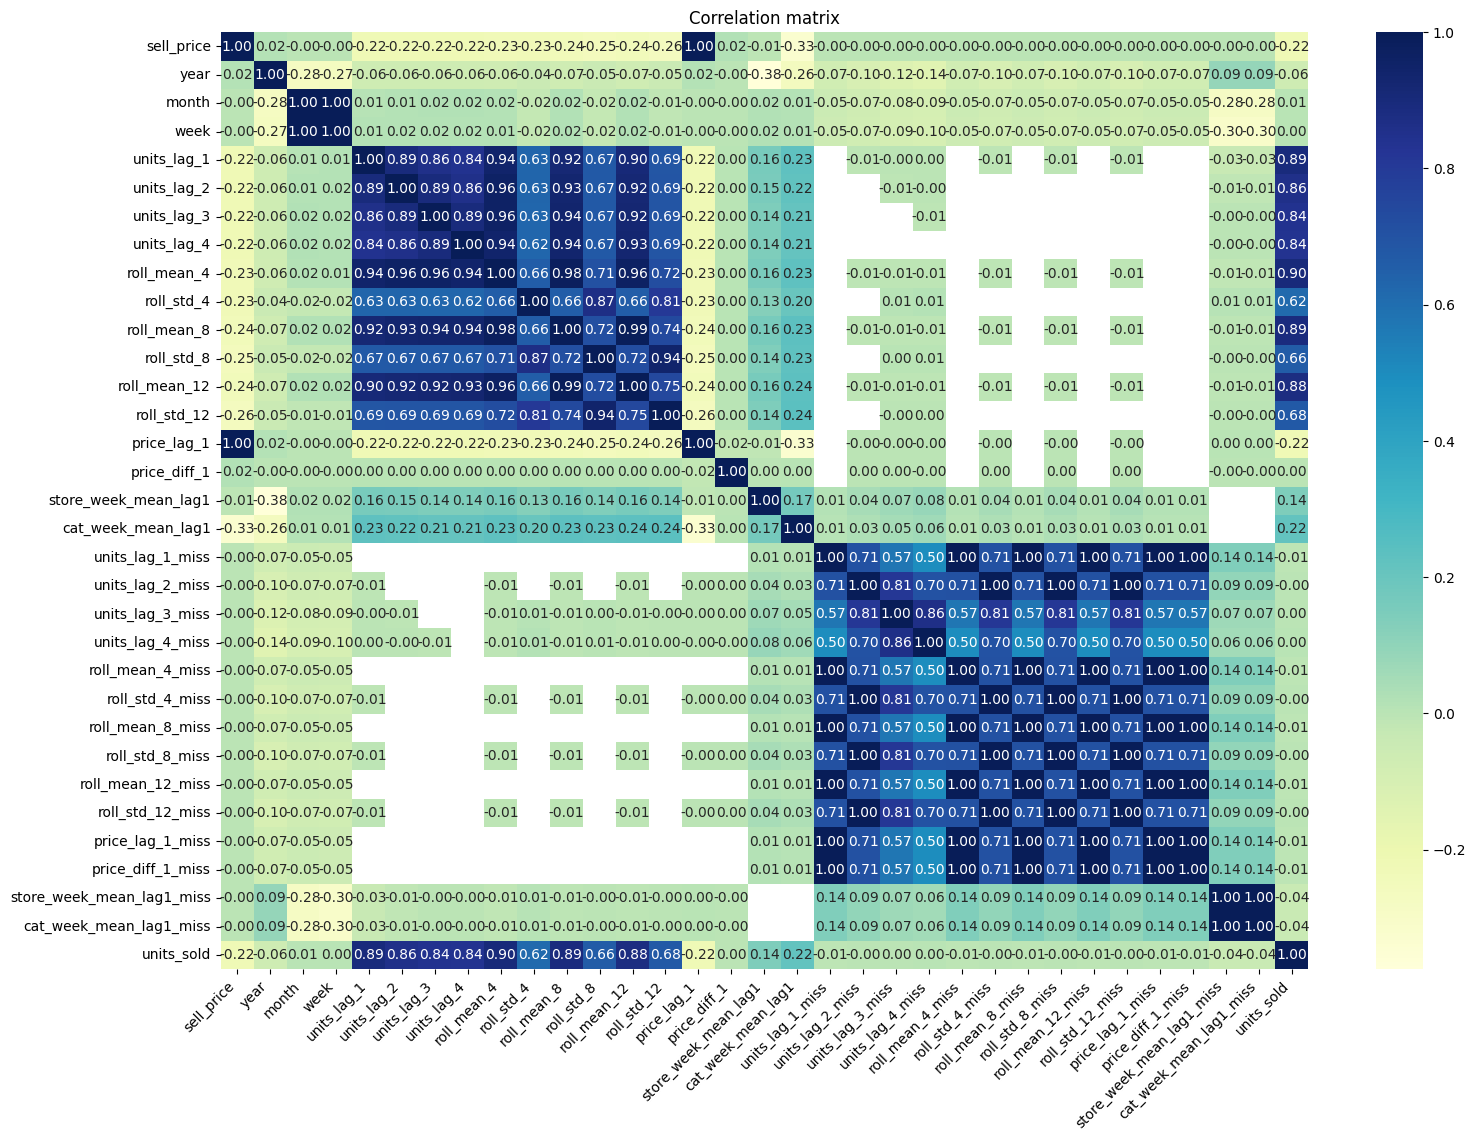

In [40]:

# Matriz de correlación
plt.figure(figsize=(16, 12))        
tmp = ds['X_train_cb'].copy()
tmp[target] = ds['y_train']
df_corr = tmp.corr(numeric_only=True)

sns.heatmap(
    df_corr,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f"                      # opcional: menos decimales
)
plt.title("Correlation matrix")
plt.tight_layout()   
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)              
plt.show()


# Model train

## Catboost

In [25]:
ds['X_train_cb'].columns

Index(['category', 'department', 'store', 'region', 'sell_price', 'event',
       'year', 'month', 'week', 'units_lag_1', 'units_lag_2', 'units_lag_3',
       'units_lag_4', 'roll_mean_4', 'roll_std_4', 'roll_mean_8', 'roll_std_8',
       'roll_mean_12', 'roll_std_12', 'price_lag_1', 'price_diff_1',
       'store_week_mean_lag1', 'cat_week_mean_lag1', 'units_lag_1_miss',
       'units_lag_2_miss', 'units_lag_3_miss', 'units_lag_4_miss',
       'roll_mean_4_miss', 'roll_std_4_miss', 'roll_mean_8_miss',
       'roll_std_8_miss', 'roll_mean_12_miss', 'roll_std_12_miss',
       'price_lag_1_miss', 'price_diff_1_miss', 'store_week_mean_lag1_miss',
       'cat_week_mean_lag1_miss'],
      dtype='object')

In [26]:
ds['X_train_cb'].isna().sum()

category                          0
department                        0
store                             0
region                            0
sell_price                        0
event                             0
year                              0
month                             0
week                              0
units_lag_1                   30334
units_lag_2                   60667
units_lag_3                   90998
units_lag_4                  121322
roll_mean_4                   30334
roll_std_4                    60667
roll_mean_8                   30334
roll_std_8                    60667
roll_mean_12                  30334
roll_std_12                   60667
price_lag_1                   30334
price_diff_1                  30334
store_week_mean_lag1         182528
cat_week_mean_lag1           182528
units_lag_1_miss                  0
units_lag_2_miss                  0
units_lag_3_miss                  0
units_lag_4_miss                  0
roll_mean_4_miss            

In [ ]:
len(ds['X_train_cb'].columns)
#drop year month

37

In [27]:
ds['X_train_cb'].describe().T

,count,mean,std,min,25%,50%,75%,max
sell_price,5382211.0,5.459679,4.144572,0.266000,2.620100,4.200000,7.176000,25.000000
year,5382211.0,2013.121905,1.276537,2011.000000,2012.000000,2013.000000,2014.000000,2015.000000
month,5382211.0,6.207427,3.438698,1.000000,3.000000,6.000000,9.000000,12.000000
week,5382211.0,25.304276,14.986585,1.000000,13.000000,24.000000,38.000000,52.000000
units_lag_1,5351877.0,9.502095,19.921164,0.000000,0.000000,3.000000,10.000000,250.000000
units_lag_2,5321544.0,9.510189,19.936905,0.000000,0.000000,3.000000,10.000000,250.000000
units_lag_3,5291213.0,9.514022,19.946264,0.000000,0.000000,3.000000,10.000000,250.000000
units_lag_4,5260889.0,9.516794,19.953457,0.000000,0.000000,3.000000,10.000000,250.000000
roll_mean_4,5351877.0,9.500825,18.945843,0.000000,1.000000,3.750000,9.500000,250.000000
roll_std_4,5321544.0,3.608614,6.161895,0.000000,0.957427,1.914854,3.872983,176.776703


In [29]:
from catboost import CatBoostRegressor, Pool

cat_idx = ds['cat_idx_cb']
Xtr, Xva = ds['X_train_cb'], ds['X_val_cb']
ytr, yva = ds['y_train'], ds['y_val']

train_pool = Pool(Xtr, ytr, cat_features=cat_idx)
valid_pool = Pool(Xva, yva, cat_features=cat_idx)

cb = CatBoostRegressor(
    task_type='GPU', devices='0',
    loss_function='Poisson',          # objetivo de conteos
    eval_metric='Poisson',
    custom_metric=['RMSE'],           # para comparar con tus runs previos
    iterations=4000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3.0,
    one_hot_max_size=16,
    max_ctr_complexity=2,
    border_count=128,
    bootstrap_type='MVS',
    subsample=0.8,
    # has_time=True,                  # <- opcional; si tu versión da guerra, comenta esto también
    od_type='Iter', od_wait=400, use_best_model=True,
    random_seed=42,
    allow_writing_files=False,
    verbose=100
)

cb.fit(train_pool, eval_set=valid_pool)


0:	learn: 0.2090737	test: 0.3474079	best: 0.3474079 (0)	total: 99ms	remaining: 6m 35s
100:	learn: -19.8748224	test: -16.4346020	best: -16.4346020 (100)	total: 6.19s	remaining: 3m 58s
200:	learn: -20.0848655	test: -16.5724293	best: -16.5724651 (199)	total: 11.7s	remaining: 3m 40s
300:	learn: -20.1429175	test: -16.5911114	best: -16.5911114 (300)	total: 17s	remaining: 3m 28s
400:	learn: -20.1645056	test: -16.6007637	best: -16.6007637 (400)	total: 22.4s	remaining: 3m 21s
500:	learn: -20.1748716	test: -16.6073344	best: -16.6073344 (500)	total: 27.5s	remaining: 3m 11s
600:	learn: -20.1884363	test: -16.6159939	best: -16.6159939 (600)	total: 33.8s	remaining: 3m 10s
700:	learn: -20.2006231	test: -16.6222242	best: -16.6222242 (700)	total: 39.8s	remaining: 3m 7s
800:	learn: -20.2111645	test: -16.6294056	best: -16.6294056 (800)	total: 45.3s	remaining: 3m 1s
900:	learn: -20.2204797	test: -16.6352418	best: -16.6352418 (900)	total: 50.6s	remaining: 2m 54s
1000:	learn: -20.2300192	test: -16.6421947	be

In [32]:
import numpy as np
from sklearn.metrics import mean_squared_error
pred = cb.predict(valid_pool)
rmse = mean_squared_error(yva, pred, squared=False)
print("RMSE(valid):", rmse)

pred_train=cb.predict(train_pool)
rmse_train = mean_squared_error(ytr, pred_train, squared=False)
print("RMSE(train):", rmse_train)
print("Overfitting:", rmse_train/rmse)


RMSE(valid): 6.988754192008797
RMSE(train): 7.939200597646264
Overfitting: 1.1359965423772154


In [35]:


# Ejemplos de entrenamiento:
# -- CatBoost --
from catboost import CatBoostRegressor, Pool
train_pool = Pool(ds['X_train_cb'], ds['y_train'], cat_features=ds['cat_idx_cb'])
valid_pool = Pool(ds['X_val_cb'],   ds['y_val'],   cat_features=ds['cat_idx_cb'])
cb = CatBoostRegressor(
    task_type='GPU', devices='0',
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    eval_metric='MAE',
    verbose=100
)
cb.fit(train_pool, eval_set=valid_pool, verbose=200)

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 9.5520150	test: 8.7128656	best: 8.7128656 (0)	total: 259ms	remaining: 4m 19s
200:	learn: 3.5225029	test: 3.2695799	best: 3.2695799 (200)	total: 49.4s	remaining: 3m 16s
400:	learn: 3.4814551	test: 3.2443047	best: 3.2443047 (400)	total: 1m 39s	remaining: 2m 28s
600:	learn: 3.4565230	test: 3.2316511	best: 3.2315802 (590)	total: 2m 30s	remaining: 1m 40s
800:	learn: 3.4403568	test: 3.2256175	best: 3.2256175 (800)	total: 3m 21s	remaining: 50s
999:	learn: 3.4281517	test: 3.2242592	best: 3.2239464 (960)	total: 4m 11s	remaining: 0us
bestTest = 3.223946401
bestIteration = 960
Shrink model to first 961 iterations.


In [ ]:

pred = cb.predict(valid_pool)
rmse = mean_squared_error(yva, pred, squared=False)
print("RMSE(valid):", rmse)

pred_train=cb.predict(train_pool)
rmse_train = mean_squared_error(ytr, pred_train, squared=False)
print("RMSE(train):", rmse_train)
print("Overfitting:", rmse_train/rmse)


RMSE(valid): 6.698510621609942
RMSE(train): 7.3344968333877985
Overfitting: 1.0949444208875496


## -- XGBoost --

Con target encoding:

In [ ]:
ds_new_te.keys()

dict_keys(['X_train_te', 'X_val_te', 'y_train', 'y_val'])

In [ ]:
# -- XGB con objective Tweedie (OHE, NaNs permitidos) --
from xgboost import XGBRegressor
from xgboost import callback

xgb_tweedie = XGBRegressor(
    tree_method="gpu_hist",        # GPU
    predictor="gpu_predictor",     # (por compatibilidad)
    
    objective='reg:tweedie',       # 1. Cambiamos a Tweedie
    tweedie_variance_power=1.5,    # 2. Añadimos el parámetro de potencia (valor inicial recomendado)
    # --------------------

    n_estimators=5000,             # alto + early stopping
    learning_rate=0.05,
    max_depth=8,                   # 12 era pesado; 8 suele ir bien
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    max_bin=256,                   # menos VRAM que 512/1024
    random_state=42
)


xgb_tweedie.fit(
    ds_new_te['X_train_te'], 
    ds_new_te['y_train'],
    eval_set=[(ds_new_te['X_val_te'], ds_new_te['y_val'])],
    eval_metric='rmse', 
    callbacks=[xgb.callback.EarlyStopping(rounds=300, save_best=True)], # Usamos el nuevo callback
    verbose=200
)

[0]	validation_0-rmse:21.62233
[200]	validation_0-rmse:8.71608
[400]	validation_0-rmse:8.68382
[600]	validation_0-rmse:8.68330
[765]	validation_0-rmse:8.71301


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=256,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

In [ ]:

# --- 2) Predicción y métrica ---
y_pred = xgb_tweedie.predict(ds_new_te['X_val_te'], iteration_range=(0, xgb_tweedie.best_iteration + 1))
rmse_val = metrics.root_mean_squared_error(ds_new_te['y_val'], y_pred)
print(f"RMSE validación: {rmse_val:,.3f}")
print(f"Best iteration: {xgb_tweedie.best_iteration}")



RMSE validación: 8.663
Best iteration: 465


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que tu modelo 'xgb_tweedie' ya ha sido entrenado
print("Generando gráfico de Feature Importance (Gain) para XGBoost...")

# Configurar el estilo y tamaño del gráfico
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 10))

# Usamos la función de ploteo de XGBoost
xgb.plot_importance(
    xgb_tweedie, 
    ax=ax, 
    importance_type='gain', # 'gain' es la contribución a la reducción del error
    max_num_features=30,    # Mostramos las 30 más importantes
    title='Feature Importance (Gain) - XGBoost'
)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd

print("Calculando Permutation Importance en el set de validación...")

# Usaremos una muestra para que no tarde demasiado, si tu set de validación es grande
X_val_sample = ds_new_te['X_val_te'].sample(n=100000, random_state=42, replace=True)
y_val_sample = ds_new_te['y_val'].loc[X_val_sample.index]

result = permutation_importance(
    xgb_tweedie,
    X_val_sample,
    y_val_sample,
    n_repeats=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Organizar y visualizar los resultados
perm_importance_df = pd.DataFrame({
    'feature': X_val_sample.columns,
    'importance_mean': result.importances_mean
}).sort_values('importance_mean', ascending=False).reset_index(drop=True)

# Visualizar
plt.figure(figsize=(12, 10))
sns.barplot(
    x=perm_importance_df['importance_mean'].head(30),
    y=perm_importance_df['feature'].head(30),
    palette='viridis'
).set_title('Permutation Importance (Impacto en RMSE) - XGBoost')
plt.xlabel('Aumento del RMSE al permutar la característica')
plt.show()

In [ ]:
# Asegúrate de tener las librerías:
# !pip install optuna tqdm

import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

# 1. Función objetivo para Optuna
def objective_xgb(trial):
    params = {
        'objective': 'reg:tweedie',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'random_state': 42,
        
        # Parámetros a optimizar
        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.1, 1.9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # Ampliamos un poco el rango para lambda
        
        'n_estimators': 5000 
    }

    model = XGBRegressor(**params)

    model.fit(
        ds_new_te['X_train_te'], 
        ds_new_te['y_train'],
        eval_set=[(ds_new_te['X_val_te'], ds_new_te['y_val'])],
        eval_metric='rmse',
        callbacks=[xgb.callback.EarlyStopping(rounds=200, save_best=True)],
        verbose=0
    )

    y_pred = model.predict(ds_new_te['X_val_te'])
    rmse = mean_squared_error(ds_new_te['y_val'], y_pred, squared=False)
    
    return rmse

# 2. Creamos y ejecutamos el estudio de Optuna
study_xgb = optuna.create_study(direction='minimize')
n_trials = 50  # Puedes aumentar este número para una búsqueda más exhaustiva

pbar = tqdm(range(n_trials), desc="Optimizando HPs para XGBoost")
for _ in pbar:
    study_xgb.optimize(objective_xgb, n_trials=1)
    pbar.set_description(f"Optimizando HPs (Mejor RMSE: {study_xgb.best_value:.4f})")

# 3. Mostramos los resultados
print("\n¡Optimización de XGBoost completada!")
print(f"Mejor RMSE encontrado: {study_xgb.best_value:.4f}")
print("Mejores hiperparámetros:")
for key, value in study_xgb.best_params.items():
    print(f"  - {key}: {value}")

[I 2025-09-18 18:18:40,167] A new study created in memory with name: no-name-f0c28d76-7035-4f19-9b0b-6af3d36a8c0c


Optimizando HPs para XGBoost:   0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-18 18:19:11,866] Trial 0 finished with value: 8.701207160949707 and parameters: {'tweedie_variance_power': 1.3743684988032892, 'learning_rate': 0.04576780391363028, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.6262503043684416, 'colsample_bytree': 0.947480159029658, 'reg_alpha': 0.00017511449573950165, 'reg_lambda': 2.412886693054885e-07}. Best is trial 0 with value: 8.701207160949707.
[I 2025-09-18 18:20:04,109] Trial 1 finished with value: 8.753373146057129 and parameters: {'tweedie_variance_power': 1.5453121471126376, 'learning_rate': 0.0448654171443406, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6091342134237036, 'colsample_bytree': 0.8596575250134357, 'reg_alpha': 0.0003589475226702454, 'reg_lambda': 3.209038217202098e-05}. Best is trial 0 with value: 8.701207160949707.
[W 2025-09-18 18:20:48,550] Trial 2 failed with parameters: {'tweedie_variance_power': 1.693107644825853, 'learning_rate': 0.016117574663645662, 'max_depth': 4, 'min_child_weight': 5,

KeyboardInterrupt: 

In [ ]:
# -- XGB con objective Tweedie (OHE, NaNs permitidos) --
from xgboost import XGBRegressor
from xgboost import callback

xgb_tweedie = XGBRegressor(
    tree_method="gpu_hist",
    predictor="gpu_predictor",

    objective="reg:tweedie",
    tweedie_variance_power=1.1023678315931387,   # <─ nuevo valor

    n_estimators=5000,
    learning_rate=0.010415264994880468,          # <─ nuevo valor
    max_depth=8,                                 # (sin cambio)
    min_child_weight=8,                           # <─ nuevo valor
    subsample=0.9756808906380359,                 # <─ nuevo valor
    colsample_bytree=0.6031127813771419,          # <─ nuevo valor
    reg_lambda=0.0011668349339570988,             # <─ nuevo valor
    reg_alpha=5.881182966364023e-06,              # <─ nuevo valor

    max_bin=256,
    random_state=42
)

xgb_tweedie.fit(
    ds['X_train_enc'], 
    ds['y_train'],
    eval_set=[(ds['X_val_enc'], ds['y_val'])],
    eval_metric='rmse', 
    callbacks=[xgb.callback.EarlyStopping(rounds=300, save_best=True)], # Usamos el nuevo callback
    verbose=200
)

[0]	validation_0-rmse:100.73673
[200]	validation_0-rmse:13.61403
[400]	validation_0-rmse:8.78581
[600]	validation_0-rmse:8.63031
[800]	validation_0-rmse:8.58536
[1000]	validation_0-rmse:8.55537
[1200]	validation_0-rmse:8.52418
[1400]	validation_0-rmse:8.50658
[1600]	validation_0-rmse:8.48427
[1800]	validation_0-rmse:8.46787
[2000]	validation_0-rmse:8.45787
[2200]	validation_0-rmse:8.45706
[2400]	validation_0-rmse:8.45520
[2600]	validation_0-rmse:8.45483
[2800]	validation_0-rmse:8.45988
[2824]	validation_0-rmse:8.45972


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6031127813771419, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.010415264994880468, max_bin=256,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

In [ ]:

# --- 2) Predicción y métrica ---
y_pred = xgb_tweedie.predict(ds['X_val_enc'], iteration_range=(0, xgb_tweedie.best_iteration + 1))
rmse_val = metrics.root_mean_squared_error(ds['y_val'], y_pred)
print(f"RMSE validación: {rmse_val:,.3f}")
print(f"Best iteration: {xgb_tweedie.best_iteration}")



RMSE validación: 8.454
Best iteration: 2524


In [ ]:
# --- 2) Predicción del train---
y_pred = xgb_tweedie.predict(ds['X_train_enc'], iteration_range=(0, xgb_tweedie.best_iteration + 1))
rmse_train = metrics.root_mean_squared_error(ds['y_train'], y_pred)
of_ratio=rmse_val/rmse_train
print(f"RMSE train: {rmse_train:,.3f}")
print(f"Overfitting ratio: {of_ratio:,.3f}")
print(f"Best iteration: {xgb_tweedie.best_iteration}")



RMSE train: 9.994
Overfitting ratio: 0.846
Best iteration: 2524


In [ ]:
# # =================================================================
# # Optimización con Optuna y Barra de Progreso (tqdm)
# # =================================================================

# import optuna
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error
# from tqdm.notebook import tqdm  # Usamos la versión para notebooks
# import time

# # 1. La función "objective" se mantiene exactamente igual que antes
# def objective(trial):
#     params = {
#         'objective': 'reg:tweedie',
#         'tree_method': 'gpu_hist',
#         'predictor': 'gpu_predictor',
#         'random_state': 42,
#         'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.1, 1.9),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#         'max_depth': trial.suggest_int('max_depth', 5, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
#         'n_estimators': 5000 
#     }
#     model = XGBRegressor(**params)
#     model.fit(
#         ds['X_train_enc'], ds['y_train'],
#         eval_set=[(ds['X_val_enc'], ds['y_val'])],
#         eval_metric='rmse',
#         callbacks=[xgb.callback.EarlyStopping(rounds=200, save_best=True)],
#         verbose=0
#     )
#     y_pred = model.predict(ds['X_val_enc'])
#     rmse = mean_squared_error(ds['y_val'], y_pred, squared=False)
#     return rmse

# # 2. Creamos el estudio de Optuna
# study = optuna.create_study(direction='minimize')

# # --- INICIO DE LA MODIFICACIÓN ---

# # 3. Definimos el número de trials y preparamos la barra de progreso
# n_trials = 50  # Número total de intentos
# pbar = tqdm(range(n_trials), desc="Optimización de HPs")

# # 4. Iteramos sobre la barra de progreso, ejecutando un trial a la vez
# for i in pbar:
#     # Ejecutamos un único trial de optimización
#     study.optimize(objective, n_trials=1)
    
#     # Actualizamos la descripción de la barra de progreso con el mejor RMSE hasta ahora
#     pbar.set_description(f"Optimización de HPs (Mejor RMSE: {study.best_value:.4f})")


# # 5. Mostramos los resultados finales (esto no cambia)
# print("\n¡Optimización completada!")
# print(f"Mejor RMSE encontrado: {study.best_value:.4f}")
# print("Mejores hiperparámetros:")
# for key, value in study.best_params.items():
#     print(f"  - {key}: {value}")

TARDA BASTANT... 1:25 
- Best is trial 12 with value: 8.454940795898438.
- params=
{'tweedie_variance_power': 1.1023678315931387, 'learning_rate': 0.010415264994880468, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9756808906380359, 'colsample_bytree': 0.6031127813771419, 'reg_alpha': 5.881182966364023e-06, 'reg_lambda': 0.0011668349339570988}. 

## LGBM

Probem d'entrenar el LGBM amb les features amb NaN's a veure que tal amb la imputació nativa del model.

In [ ]:
# import lightgbm as lgb
# from sklearn.metrics import mean_squared_error

# # 3. Entrena usando los dataframes "nativos"
# lgbm_nativo = lgb.LGBMRegressor(
#     # --- PARÁMETRO AÑADIDO ---
#     device_type='gpu',         # ¡Esta es la línea clave para activar la GPU!
#     objective='tweedie',
#     tweedie_variance_power=1.1,
#     n_estimators=5000,
#     learning_rate=0.01,
#     max_depth=8,
#     min_child_weight=8,
#     subsample=0.975,
#     colsample_bytree=0.6,
#     reg_alpha=5.88e-06,
#     reg_lambda=0.00116,
#     random_state=42
# )

# print("Iniciando entrenamiento en GPU con manejo nativo de categóricas...")

# lgbm_nativo.fit(
#     ds_new['X_train_native'],
#     ds_new['y_train'],
#     eval_set=[(ds_new['X_val_native'], ds_new['y_val'])],
#     eval_metric='rmse',
#     callbacks=[lgb.early_stopping(100, verbose=False)],
#     categorical_feature=ds_new['cat_cols'] # Le indicamos las categóricas
# )

# # 4. Evalúa
# y_pred_nativo = lgbm_nativo.predict(ds_new['X_val_native'])
# rmse_nativo = mean_squared_error(ds_new['y_val'], y_pred_nativo, squared=False)

# print(f"\nEntrenamiento completado.")
# print(f"RMSE final con manejo nativo y nuevas features: {rmse_nativo:.4f}")

Tarda més del compte, resultats molt similars, així que millor utilizar la versió amb OHE

In [ ]:

# -- LightGBM (OHE, NaNs permitidos) --
from lightgbm import LGBMRegressor, early_stopping
lgbm = LGBMRegressor(
    device_type='gpu', boosting_type='gbdt',
    n_estimators=3000, learning_rate=0.05,
    num_leaves=31, max_depth=-1,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
lgbm.fit(ds['X_train_enc'], ds['y_train'],
         eval_set=[(ds['X_val_enc'], ds['y_val'])],
         eval_metric='rmse',
         callbacks=[early_stopping(stopping_rounds=300, verbose=False)])


  File "c:\Users\teser\.conda\envs\env_main_conda\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\teser\.conda\envs\env_main_conda\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\teser\.conda\envs\env_main_conda\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\teser\.conda\envs\env_main_conda\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3969
[LightGBM] [Info] Number of data points in the train set: 5382211, number of used features: 56
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (123.19 MB) transferred to GPU in 0.118851 secs. 1 sparse feature groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 10.007157


LGBMRegressor(colsample_bytree=0.8, device_type='gpu', learning_rate=0.05,
              n_estimators=3000, random_state=42, subsample=0.8)

In [ ]:
y_pred=lgbm.predict(ds['X_val_enc'], num_iteration=lgbm.best_iteration_)

rmse = metrics.root_mean_squared_error(ds['y_val'], y_pred)
print(f"RMSE validación: {rmse:,.3f}")


RMSE validación: 7.971


In [ ]:
y_pred_train=lgbm.predict(ds['X_train_enc'], num_iteration=lgbm.best_iteration_)
rmse_train = metrics.root_mean_squared_error(ds['y_train'], y_pred_train)
of_ratio=rmse/rmse_train
print(f"RMSE train: {rmse_train:,.3f}")
print(f"Overfitting ratio: {of_ratio:,.3f}")
print(f"Best iteration: {lgbm.best_iteration_}")

RMSE train: 8.840
Overfitting ratio: 0.956
Best iteration: 911


## Feature Importance (LGBM)

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de los gráficos
sns.set(style='whitegrid')

# --- Feature Importance del modelo LightGBM ---
print("Generando gráfico de Feature Importance (Gain)...")

# El modelo entrenado se llama 'lgbm', lo cual es correcto.
# El error estaba en no haber importado 'lightgbm as lgb' para usar la función de ploteo.
fig, ax = plt.subplots(figsize=(12, 10))
lgb.plot_importance(
    lgbm, 
    ax=ax, 
    importance_type='gain', # 'gain' es la contribución total a la reducción del error
    max_num_features=30,    # Mostramos las 30 más importantes
    title='Feature Importance (Gain) - LightGBM'
)
plt.tight_layout()
plt.show()

## Permutation Importance

In [ ]:

# Crea una muestra más pequeña para un cálculo mucho más rápido
SAMPLE_SIZE = 100000  # Prueba con 100k filas, ajusta según necesidad
if SAMPLE_SIZE > len(ds['X_val_enc']):
    SAMPLE_SIZE = len(ds['X_val_enc']) # Asegurarse de no exceder el tamaño real

X_val_sample = ds['X_val_enc'].sample(n=SAMPLE_SIZE, random_state=42)
y_val_sample = ds['y_val'].loc[X_val_sample.index]

print(f"Usando una muestra de {len(X_val_sample)} filas para la permutación...")

# Ahora ejecuta la importancia por permutación sobre la muestra
result_sample = permutation_importance(
    lgbm,
    X_val_sample,
    y_val_sample,
    n_repeats=5, # Puedes mantener 5 con la muestra, será rápido
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# El código para visualizar los resultados es el mismo que antes,
# solo que usando 'result_sample' y 'X_val_sample.columns'
perm_importance_df_sample = pd.DataFrame({
    'feature': X_val_sample.columns,
    'importance_mean': result_sample.importances_mean,
    'importance_std': result_sample.importances_std
}).sort_values('importance_mean', ascending=False).reset_index(drop=True)


Usando una muestra de 100000 filas para la permutación...


In [ ]:
# Mostramos las 30 características más importantes
top_30_perm = perm_importance_df_sample.head(30)

# Visualizamos los resultados
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(
    x=top_30_perm['importance_mean'],
    y=top_30_perm['feature'],
    ax=ax,
    palette='viridis'
)
ax.set_title('Permutation Importance (Impacto en RMSE) - Validation Set')
ax.set_xlabel('Aumento del RMSE al permutar la característica')
ax.set_ylabel('Característica')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# --- 1. Obtener y Preparar Ambos Tipos de Importancia ---

# a) Importancia por Ganancia (del modelo lgbm)
gain_importance_df = pd.DataFrame({
    # --- LÍNEA CORREGIDA ---
    # Usamos los nombres de columna originales del DataFrame para asegurar la coincidencia.
    # LightGBM garantiza que el orden de las importancias coincide con el de las columnas de entrada.
    'feature': ds['X_train_enc'].columns,
    'gain_importance': lgbm.booster_.feature_importance(importance_type='gain')
})

# b) Importancia por Permutación (ya la teníamos en perm_importance_df)
perm_importance_df_subset = perm_importance_df_sample[['feature', 'importance_mean']]


# --- 2. Unir ambas métricas en un solo DataFrame ---
df_importances = pd.merge(gain_importance_df, perm_importance_df_subset, on='feature', how='outer').fillna(0)


# --- 3. Escalar las Importancias al Rango [0, 1] ---
scaler = MinMaxScaler()
df_importances[['gain_scaled', 'perm_scaled']] = scaler.fit_transform(
    df_importances[['gain_importance', 'importance_mean']]
)


# --- 4. Calcular tu Puntuación Híbrida ---
df_importances['hybrid_score'] = (
    0.6 * df_importances['perm_scaled'] + 
    0.4 * df_importances['gain_scaled']
)
df_importances_ranked = df_importances.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

print("--- Ranking Híbrido de Características (Top 20) ---")
print(df_importances_ranked.head(20)[['feature', 'hybrid_score', 'perm_scaled', 'gain_scaled']])


# --- 5. Seleccionar las 'Top N' Características y Re-entrenar ---
N_FEATURES_A_CONSERVAR = 40 
features_a_conservar = df_importances_ranked.head(N_FEATURES_A_CONSERVAR)['feature'].tolist()

print(f"\nSeleccionando las {N_FEATURES_A_CONSERVAR} mejores características según el ranking híbrido.")

X_train_reducido_hibrido = ds['X_train_enc'][features_a_conservar]
X_val_reducido_hibrido = ds['X_val_enc'][features_a_conservar]


# --- 6. Re-entrenar y Evaluar ---
print("Re-entrenando el modelo con el nuevo conjunto de características...")

params = lgbm.get_params()
if 'importance_type' in params:
    del params['importance_type']
    
lgbm_reducido_hibrido = lgb.LGBMRegressor(**params) 
lgbm_reducido_hibrido.fit(
    X_train_reducido_hibrido, 
    ds['y_train'],
    eval_set=[(X_val_reducido_hibrido, ds['y_val'])],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(100, verbose=False)]
)

y_pred_reducido_hibrido = lgbm_reducido_hibrido.predict(X_val_reducido_hibrido)
rmse_reducido_hibrido = mean_squared_error(ds['y_val'], y_pred_reducido_hibrido, squared=False)

print(f"\nRMSE con modelo reducido (Ranking Híbrido): {rmse_reducido_hibrido:.4f}")

--- Ranking Híbrido de Características (Top 20) ---
                     feature  hybrid_score  perm_scaled  gain_scaled
0                units_lag_1      1.000000     1.000000     1.000000
1                roll_mean_4      0.399439     0.279958     0.578661
2                roll_mean_8      0.096016     0.127854     0.048258
3               roll_mean_12      0.083659     0.101845     0.056382
4                units_lag_2      0.059074     0.085362     0.019642
5                       week      0.022399     0.028108     0.013835
6                units_lag_4      0.017826     0.016623     0.019632
7         cat_week_mean_lag1      0.010406     0.006549     0.016190
8       store_week_mean_lag1      0.010019     0.008797     0.011852
9   department_SUPERMARKET_3      0.007757     0.012566     0.000544
10                roll_std_4      0.007318     0.009639     0.003838
11               units_lag_3      0.006901     0.002886     0.012924
12               roll_std_12      0.004823     0.00

In [ ]:
X_train_reducido_hibrido.columns

Index(['units_lag_1', 'roll_mean_4', 'roll_mean_8', 'roll_mean_12',
       'units_lag_2', 'week', 'units_lag_4', 'cat_week_mean_lag1',
       'store_week_mean_lag1', 'department_SUPERMARKET_3', 'roll_std_4',
       'units_lag_3', 'roll_std_12', 'sell_price', 'price_diff_1',
       'price_lag_1', 'month', 'store_Tribeca', 'year', 'roll_std_8',
       'event_Thanksgiving', 'region_Philadelphia', 'event_NewYear',
       'category_SUPERMARKET', 'event_Unknown', 'department_SUPERMARKET_2',
       'department_ACCESORIES_2', 'department_SUPERMARKET_1',
       'department_HOME_&_GARDEN_2', 'store_Yorktown', 'store_Harlem',
       'store_Brooklyn', 'store_week_mean_lag1_miss', 'region_New York',
       'event_SuperBowl', 'store_Greenwich_Village',
       'department_HOME_&_GARDEN_1', 'store_Roxbury',
       'cat_week_mean_lag1_miss', 'store_Queen_Village'],
      dtype='object')

# Dealing with the Zero Inflated Problem

In [ ]:
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import mean_squared_error

# Asegúrate de que tu diccionario 'ds' esté disponible
# ds = build_datasets(df_sorted)

print("Entrenando el modelo de dos etapas (versión directa)...")

# --- 1. Crear targets para el clasificador usando 'ds' ---
y_train_clf = (ds['y_train'] > 0).astype(int)
y_val_clf = (ds['y_val'] > 0).astype(int)

# --- 2. Entrenar un clasificador (LGBM es rápido y bueno) ---
clf = LGBMClassifier(objective='binary', device_type='gpu', random_state=42)
clf.fit(ds['X_train_enc'], y_train_clf)

# Obtener la probabilidad de que la venta > 0
prob_sales_val = clf.predict_proba(ds['X_val_enc'])[:, 1]

# --- 3. Filtrar datos para el regresor (solo ventas > 0) usando 'ds' ---
# Creamos una máscara booleana para filtrar
train_sales_mask = ds['y_train'] > 0
X_train_reg = ds['X_train_enc'][train_sales_mask]
y_train_reg = ds['y_train'][train_sales_mask]

# --- 4. Entrenar el regresor con loss Poisson (o Tweedie) ---
reg = LGBMRegressor(objective='tweedie', tweedie_variance_power=1.5, device_type='gpu', random_state=42)
reg.fit(X_train_reg, y_train_reg)

# Predecir el valor de la venta
value_sales_val = reg.predict(ds['X_val_enc'])

# --- 5. Combinar predicciones ---
y_pred_final = prob_sales_val * value_sales_val

# --- 6. Calcular RMSE final ---
final_rmse = mean_squared_error(ds['y_val'], y_pred_final, squared=False)
print(f"RMSE del modelo de 2 etapas (directo): {final_rmse:,.3f}")

Entrenando el modelo de dos etapas (versión directa)...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4020970, number of negative: 1361241
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3969
[LightGBM] [Info] Number of data points in the train set: 5382211, number of used features: 56
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (123.19 MB) transferred to GPU in 0.087224 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.747085 -> initscore=1.083126
[LightGBM] [Info] Start training from score 1.083126
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU t

In [ ]:
ds['X_train_enc'].columns

Index(['sell_price', 'year', 'month', 'week', 'units_lag_1', 'units_lag_2',
       'units_lag_3', 'units_lag_4', 'roll_mean_4', 'roll_std_4',
       'roll_mean_8', 'roll_std_8', 'roll_mean_12', 'roll_std_12',
       'price_lag_1', 'price_diff_1', 'store_week_mean_lag1',
       'cat_week_mean_lag1', 'units_lag_1_miss', 'units_lag_2_miss',
       'units_lag_3_miss', 'units_lag_4_miss', 'roll_mean_4_miss',
       'roll_std_4_miss', 'roll_mean_8_miss', 'roll_std_8_miss',
       'roll_mean_12_miss', 'roll_std_12_miss', 'price_lag_1_miss',
       'price_diff_1_miss', 'store_week_mean_lag1_miss',
       'cat_week_mean_lag1_miss', 'category_HOME_&_GARDEN',
       'category_SUPERMARKET', 'department_ACCESORIES_2',
       'department_HOME_&_GARDEN_1', 'department_HOME_&_GARDEN_2',
       'department_SUPERMARKET_1', 'department_SUPERMARKET_2',
       'department_SUPERMARKET_3', 'store_Brooklyn', 'store_Greenwich_Village',
       'store_Harlem', 'store_Midtown_Village', 'store_Queen_Village',
    

--- Ranking Híbrido de Características (Top 20) ---
                     feature  hybrid_score  perm_scaled  gain_scaled
0                units_lag_1      1.000000     1.000000     1.000000
1                roll_mean_4      0.399439     0.279958     0.578661
2                roll_mean_8      0.096016     0.127854     0.048258
3               roll_mean_12      0.083659     0.101845     0.056382
4                units_lag_2      0.059074     0.085362     0.019642
5                       week      0.022399     0.028108     0.013835
6                units_lag_4      0.017826     0.016623     0.019632
7         cat_week_mean_lag1      0.010406     0.006549     0.016190
8       store_week_mean_lag1      0.010019     0.008797     0.011852
9   department_SUPERMARKET_3      0.007757     0.012566     0.000544
10                roll_std_4      0.007318     0.009639     0.003838
11               units_lag_3      0.006901     0.002886     0.012924
12               roll_std_12      0.004823     0.00

In [ ]:
X_train_reducido_hibrido.columns

Index(['units_lag_1', 'roll_mean_4', 'roll_mean_8', 'roll_mean_12',
       'units_lag_2', 'week', 'units_lag_4', 'cat_week_mean_lag1',
       'store_week_mean_lag1', 'department_SUPERMARKET_3', 'roll_std_4',
       'units_lag_3', 'roll_std_12', 'sell_price', 'price_diff_1',
       'price_lag_1', 'month', 'store_Tribeca', 'year', 'roll_std_8',
       'event_Thanksgiving', 'region_Philadelphia', 'event_NewYear',
       'category_SUPERMARKET', 'event_Unknown', 'department_SUPERMARKET_2',
       'department_ACCESORIES_2', 'department_SUPERMARKET_1',
       'department_HOME_&_GARDEN_2', 'store_Yorktown', 'store_Harlem',
       'store_Brooklyn', 'store_week_mean_lag1_miss', 'region_New York',
       'event_SuperBowl', 'store_Greenwich_Village',
       'department_HOME_&_GARDEN_1', 'store_Roxbury',
       'cat_week_mean_lag1_miss', 'store_Queen_Village'],
      dtype='object')

In [ ]:
# !jupyter nbconvert --to markdown "Time_Series_model.ipynb"


Teniendo en cuenta la presencia mayoritaria de ceros en la target, podria ser una buena idea:
- Primero entrenar un algoritmo de clasificación para predecir: ventas =0 / !=0.
- Segundo entrenar un algoritmo de regresión para predecir el valor de las ventas != 0.
NO RESULTA EN UNA MEJORA, TWEEDIE ES SUFICIENTE BUENO POR SI SOLO


FEATURE PRUNNING: Quedate  con tu modelo de 40 características. Es un excelente baseline: robusto y simplificado.

VISUALIZAR PREDICCIONES!